* apply histogram matching

In [20]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio as rio
import geopandas as gpd
import pandas as pd
import os
from shapely import wkt
from shapely.geometry import box
import leafmap.foliumap as leafmap
import folium
import rioxarray as rioxr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import skimage.io as io

In [2]:
from PIL import Image

In [3]:
pd.options.display.max_columns = 50

In [4]:
from src.rs_processing.processing import get_meta_img

In [5]:
from src.config import *
from src.io.utils_io import load_maxar_items, load_rs_path_toy, load_roi_town, check_dir, make_path, save_pickle
from src.stac.utils_stac import get_nearest_match_geometry_view
from src.utils import create_bbox, get_maxar_items_on_roi
from src.rs_processing.processing import crop_rs_on_shape
from src.io.utils_io import load_pair_raster,make_path,load_pickle


In [6]:
CRS = 32629

In [7]:
project_path = os.path.expanduser("~/Documents/Projects/building_damage")
out_dir_path = os.path.join(project_path, "Data/processed")
building_root_path = os.path.join(project_path, "Data/raw/building_footprint")
raw_data_path = os.path.join(project_path, "Data/raw")

In [8]:
name = "Adassil"
delta_event = "before"
rs_test_path = os.path.join(out_dir_path, name, delta_event, "1030010083A10700-visual.tif")

In [13]:
dataset = load_pickle(make_path("dataset_visual_157.pkl", processed_dir_path, "dataset", "png"))
dataset_labelled = load_pickle(make_path("dataset_labelled.pkl", processed_dir_path, "dataset", "png", "data_labelled"))

### Calibration

In [9]:
rs = rioxr.open_rasterio(rs_test_path)

<Axes: >

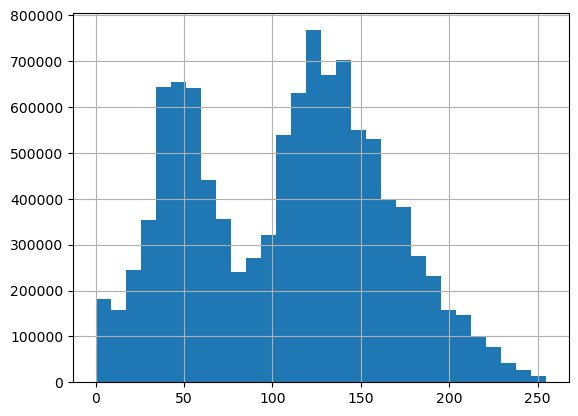

In [21]:
pd.Series(rs.sel(band=1).data.flatten()).hist(bins=30)

OK déjà en reflectance

### Histogram matching

In [24]:
from skimage.exposure import match_histograms

In [7]:
type_item = "visual"
#name = "Talat_Nyaaqoub"
name = "Amzi"

zoom=200

In [52]:
nearest_crop = load_pickle(make_path(f"nearest_{type_item}.pkl", processed_dir_path, type_item))

In [53]:
maxar_items = load_maxar_items(type_item="visual")

In [54]:
maxar_items.href.nunique()

8724

In [55]:
maxar_items.columns

Index(['id', 'type', 'title', 'href', 'datetime', 'platform', 'gsd',
       'catalog_id', 'utm_zone', 'quadkey', 'view_off_nadir', 'view_azimuth',
       'view_incidence_angle', 'view_sun_azimuth', 'view_sun_elevation',
       'proj_epsg', 'grid_code', 'data_area', 'clouds_area', 'clouds_percent',
       'geometry_bbox', 'geometry', 'after_event'],
      dtype='object')

In [56]:
nearest_crop.keys()

dict_keys(['Adassil', 'Tafeghaghte', 'Mejdid', 'Amzi', 'Tinzert', 'Taroudant', 'Talat_Nyaaqoub', 'Tassouante'])

In [91]:
nearest_crop = load_pickle(make_path(f"rgsted_{type_item}.pkl", processed_dir_path, type_item))

In [8]:
nearest_meta = load_pickle(make_path(f"nearest_{type_item}.pkl", interim_dir_path, type_item))

In [10]:
maxar_items = load_maxar_items(type_item="visual")

In [11]:
maxar_items.columns

Index(['id', 'type', 'title', 'href', 'datetime', 'platform', 'gsd',
       'catalog_id', 'utm_zone', 'quadkey', 'view_off_nadir', 'view_azimuth',
       'view_incidence_angle', 'view_sun_azimuth', 'view_sun_elevation',
       'proj_epsg', 'grid_code', 'data_area', 'clouds_area', 'clouds_percent',
       'geometry_bbox', 'geometry', 'after_event'],
      dtype='object')

In [22]:
maxar_items[(maxar_items.view_off_nadir > 24.1) & (maxar_items.view_off_nadir < 24.3)]

,id,type,title,href,datetime,platform,gsd,catalog_id,utm_zone,quadkey,view_off_nadir,view_azimuth,view_incidence_angle,view_sun_azimuth,view_sun_elevation,proj_epsg,grid_code,data_area,clouds_area,clouds_percent,geometry_bbox,geometry,after_event
21,29/031313133323/04eddade-a2dc-4d16-8710-fb764d...,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2018-08-31 11:25:50Z,WV04,0.36,04eddade-a2dc-4d16-8710-fb764d318766-inv,29,031313133323,24.100000,114.699997,63.4,139.0,62.7,32629,MXRA-Z29-031313133323,28.203125,0.000000,0.0,"[484843.75, 3359843.75, 490156.25, 3365156.25]","POLYGON ((484843.750 3365156.250, 490156.250 3...",0
79,29/031313133312/04eddade-a2dc-4d16-8710-fb764d...,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2018-08-31 11:25:52Z,WV04,0.36,04eddade-a2dc-4d16-8710-fb764d318766-inv,29,031313133312,24.299999,119.099998,63.1,139.1,62.7,32629,MXRA-Z29-031313133312,28.203125,0.000000,0.0,"[489843.75, 3369843.75, 495156.25, 3375156.25]","POLYGON ((489843.750 3375156.250, 495156.250 3...",0
157,29/031313133322/04eddade-a2dc-4d16-8710-fb764d...,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2018-08-31 11:25:50Z,WV04,0.36,04eddade-a2dc-4d16-8710-fb764d318766-inv,29,031313133322,24.299999,114.400002,63.2,139.0,62.7,32629,MXRA-Z29-031313133322,11.101562,0.000000,0.0,"[483035.888671875, 3359843.75, 485156.25, 3365...","POLYGON ((483035.889 3365156.250, 485156.250 3...",0
1751,29/031313311100/04eddade-a2dc-4d16-8710-fb764d...,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2018-08-31 11:25:50Z,WV04,0.36,04eddade-a2dc-4d16-8710-fb764d318766-inv,29,031313311100,24.100000,112.400002,63.4,138.9,62.8,32629,MXRA-Z29-031313311100,11.000000,0.000000,0.0,"[483061.5234375, 3354843.75, 485156.25, 336015...","POLYGON ((483061.523 3360156.250, 485156.250 3...",0
2703,29/120200232132/10300500E4F92200,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2023-09-11 11:08:38Z,WV02,0.55,10300500E4F92200,29,120200232132,24.299999,121.900002,62.6,141.6,56.9,32629,MXRA-Z29-120200232132,0.500000,0.000000,0.0,"[611182.5561523438, 3544844.970703125, 614518....","POLYGON ((611182.556 3545156.250, 614512.634 3...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8484,29/120202013100/10500500F3DD9500,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2021-09-22 11:29:49Z,GE01,0.48,10500500F3DD9500,29,120202013100,24.100000,319.200012,63.1,155.7,56.5,32629,MXRA-Z29-120202013100,28.203125,1.400391,5.0,"[639843.75, 3474843.75, 645156.25, 3480156.25]","POLYGON ((639843.750 3480156.250, 645156.250 3...",0
8491,29/120202013011/10500500F3DD9500,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2021-09-22 11:29:49Z,GE01,0.48,10500500F3DD9500,29,120202013011,24.100000,319.500000,63.2,155.7,56.5,32629,MXRA-Z29-120202013011,3.199219,0.000000,0.0,"[639517.2119140625, 3474843.75, 640156.25, 348...","POLYGON ((639528.198 3480156.250, 640156.250 3...",0
8505,29/120200232121/105005007BDD8F00,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2019-11-10 11:09:06Z,GE01,0.48,105005007BDD8F00,29,120200232121,24.100000,81.300003,63.1,159.6,38.5,32629,MXRA-Z29-120200232121,28.203125,0.000000,0.0,"[604843.75, 3544843.75, 610156.25, 3550156.25]","POLYGON ((604843.750 3550156.250, 610156.250 3...",0
8540,29/120200232102/105005007BDD8F00,image/tiff; application=geotiff; profile=cloud...,Visual Image,https://maxar-opendata.s3.amazonaws.com/events...,2019-11-10 11:09:07Z,GE01,0.48,105005007BDD8F00,29,120200232102,24.299999,83.599998,62.9,1

In [14]:
maxar_items.groupby("view_off_nadir")["after_event"].value_counts()

view_off_nadir  after_event
0.500000        0              1
0.600000        0              2
0.700000        0              3
0.800000        0              2
0.900000        0              4
                              ..
43.200001       1              5
43.299999       1              6
43.400002       1              6
43.500000       1              6
43.599998       1              3
Name: count, Length: 396, dtype: int64

In [92]:
nearest_crop

,rs_b_path,rs_a_path,corr,corr_ref,geometry,name
0,/home/rustt/Documents/Projects/building_damage...,/home/rustt/Documents/Projects/building_damage...,0.405261,0.398222,"POLYGON ((548109.131 3441773.987, 548109.131 3...",Adassil
1,/home/rustt/Documents/Projects/building_damage...,/home/rustt/Documents/Projects/building_damage...,0.325317,0.399373,"POLYGON ((574171.753 3451395.264, 574171.753 3...",Tafeghaghte
2,/home/rustt/Documents/Projects/building_damage...,/home/rustt/Documents/Projects/building_damage...,0.517435,0.451019,"POLYGON ((548761.902 3442642.822, 548761.902 3...",Mejdid
3,/home/rustt/Documents/Projects/building_damage...,/home/rustt/Documents/Projects/building_damage...,0.468799,0.498603,"POLYGON ((576044.312 3451337.891, 576044.312 3...",Amzi
4,/home/rustt/Documents/Projects/building_damage...,/home/rustt/Documents/Projects/building_damage...,0.188067,0.129832,"POLYGON ((594624.023 3450856.934, 594624.023 3...",Tinzert
5,/home/rustt/Documents/Projects/building_damage...,/home/rustt/Documents/Projects/building_damage...,0.483078,0.473039,"POLYGON ((512236.023 3371060.791, 512236.023 3...",Taroudant
6,/home/rustt/Documents/Projects/building_damage...,/home/rustt/Documents/Projects/building_damage...,0.646462,0.582721,"POLYGON ((578144.836 3428529.663, 578144.836 3...",Talat_Nyaaqoub
7,/home/rustt/Documents/Projects/building_damage...,/home/rustt/Documents/Projects/building_damage...,0.707808,0.652486,"POLYGON ((577288.208 3428147.888, 577288.208 3...",Tassouante


In [93]:
rs_dict = load_pair_raster(source=nearest_crop, zoom=zoom, name=name)
rs_b, rs_a = rs_dict.values()
arr_b, arr_a = rs_b.data.transpose(1, 2, 0), rs_a.data.transpose(1, 2, 0)

In [94]:
arr_a.dtype

dtype('uint8')

In [95]:
rs_b.rio.bounds()

(575643.9208984375, 3451337.890625, 576044.3115234375, 3451738.28125)

In [98]:
matched = match_histograms(arr_a, arr_b, channel_axis=-1)

In [79]:
matched = matched.astype(np.uint16)
arr_b = arr_b.astype(np.uint16)
arr_a = arr_a.astype(np.uint16)

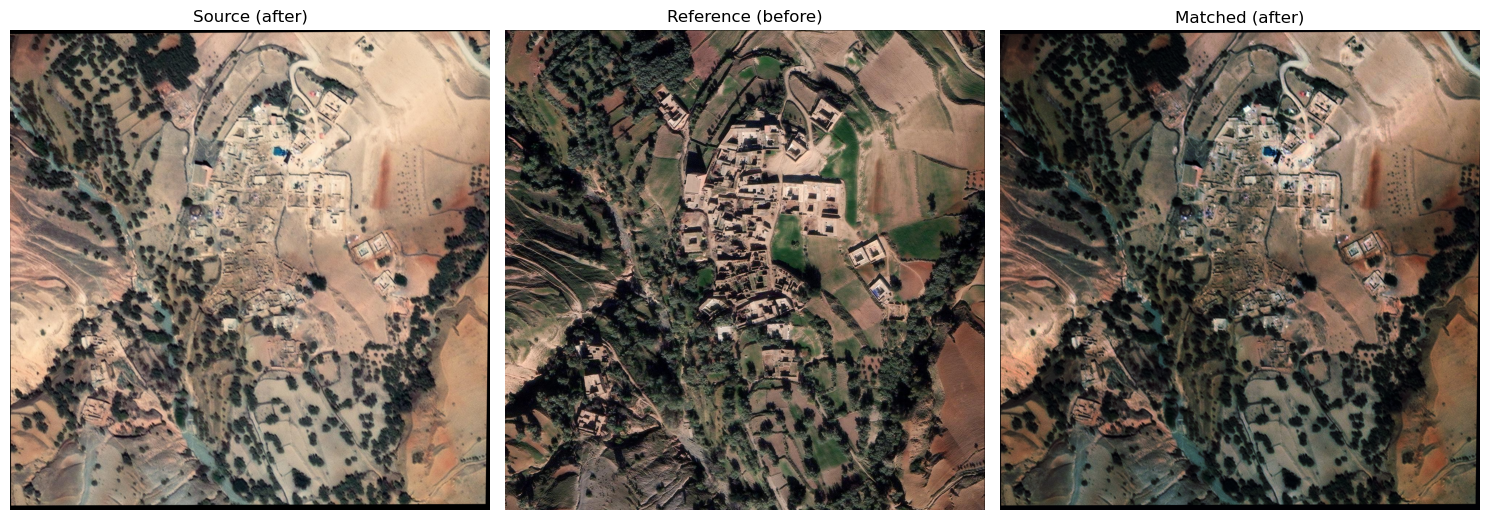

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 7),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(arr_a)
ax1.set_title('Source (after)')
ax2.imshow(arr_b)
ax2.set_title('Reference (before)')
ax3.imshow(matched)
ax3.set_title('Matched (after)')

plt.tight_layout()

In [14]:
img_id = "465955c3-57fd-4b53-b347-1e9ea61d26d7"
row = dataset[dataset.img_id == img_id]
row_label = dataset_labelled[dataset_labelled.img_id == img_id]

In [15]:
row.columns

Index(['before_path', 'after_path', 'town_name', 'geometry', 'quadkey',
       'before_href', 'before_view_off_nadir', 'before_view_azimuth',
       'before_view_incidence_angle', 'before_view_sun_azimuth',
       'before_view_sun_elevation', 'before_platform', 'before_clouds_percent',
       'after_href', 'after_view_off_nadir', 'after_view_azimuth',
       'after_view_incidence_angle', 'after_view_sun_azimuth',
       'after_view_sun_elevation', 'after_platform', 'after_clouds_percent',
       'id_pair', 'diff_view_off_nadir', 'diff_view_incidence',
       'diff_view_sun_azimuth', 'diff_avg', 'before_path_png',
       'after_path_png', 'img_id', 'urban_area_path'],
      dtype='object')

In [16]:
row_label.columns

Index(['annotation_id', 'labels_path', 'img_id', 'after_path', 'before_path'], dtype='object')

In [17]:
row.columns

Index(['before_path', 'after_path', 'town_name', 'geometry', 'quadkey',
       'before_href', 'before_view_off_nadir', 'before_view_azimuth',
       'before_view_incidence_angle', 'before_view_sun_azimuth',
       'before_view_sun_elevation', 'before_platform', 'before_clouds_percent',
       'after_href', 'after_view_off_nadir', 'after_view_azimuth',
       'after_view_incidence_angle', 'after_view_sun_azimuth',
       'after_view_sun_elevation', 'after_platform', 'after_clouds_percent',
       'id_pair', 'diff_view_off_nadir', 'diff_view_incidence',
       'diff_view_sun_azimuth', 'diff_avg', 'before_path_png',
       'after_path_png', 'img_id', 'urban_area_path'],
      dtype='object')

### KDE

In [21]:
arr_b = rioxr.open_rasterio(row["before_path"].item()).data.transpose(1, 2, 0)
arr_al = io.imread(row_label["after_path"].item())
arr_a = rioxr.open_rasterio(row["after_path"].item()).data.transpose(1, 2, 0)                          

In [25]:
arr_ln = match_histograms(arr_a, arr_b, channel_axis=-1)

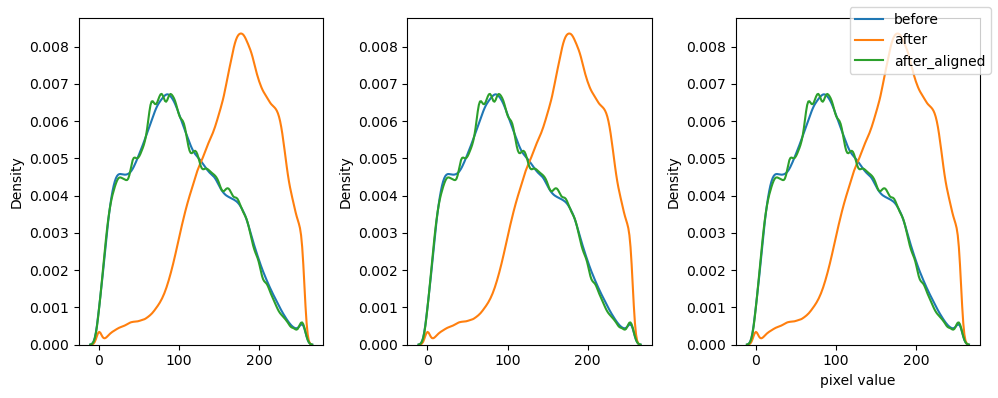

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    sns.kdeplot(pd.Series(arr_b[:, :, 0].flatten()), label="before", ax=axes[i])
    sns.kdeplot(pd.Series(arr_a[:, :, 0].flatten()), label="after", ax=axes[i])
    sns.kdeplot(pd.Series(arr_al[:, :, 0].flatten()), label="after_aligned", ax=axes[i])
    plt.xlabel("pixel value")
    #plt.title("Kernel Density Estimation")
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()

In [36]:
im = Image.fromarray(matched)

In [38]:
im.save(make_path("nearest.png", interim_dir_path, type_item, name))

In [31]:
matched.shape

(3, 1311, 1312)

In [39]:
make_path("nearest", interim_dir_path, type_item, name)

'/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/interim/visual/Talat_Nyaaqoub/nearest'

### save png for building extraction test

In [6]:
type_item = "visual"
#name = "Talat_Nyaaqoub"
name = "Amzi"

zoom=200

In [9]:
nearest_crop = load_pickle(make_path(f"rgsted_{type_item}.pkl", processed_dir_path, type_item))

In [13]:
from PIL import Image
from pathlib import Path

In [14]:
if not os.path.exists(os.path.join(project_path, "data", "tmp")):
    os.mkdir(os.path.join(project_path, "data", "tmp"))
out_dir = os.path.join(project_path, "data", "tmp")
for path in nearest_crop.before_path:
    im_name = Path(path).stem
    im = Image.open(path)
    im.save(os.path.join(out_dir, im_name+".png"), "PNG")

## Annexe

### Co-registration | resolution alignment

=> done with Loftr (try)

https://pygis.io/docs/e_raster_resample.html

```python
def reproj_match(infile, match, outfile):
    """Reproject a file to match the shape and projection of existing raster. 
    
    Parameters
    ----------
    infile : (string) path to input file to reproject
    match : (string) path to raster with desired shape and projection 
    outfile : (string) path to output file tif
    """
    # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs
            
            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({"crs": dst_crs,
                           "transform": dst_transform,
                           "width": dst_width,
                           "height": dst_height,
                           "nodata": 0})
        print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
        # open output
        with rasterio.open(outfile, "w", **dst_kwargs) as dst:
            # iterate through bands and write using reproject function
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)